# Import necessary libraries

In [106]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud

# Load dataset

In [107]:
anime = pd.read_csv('anime.csv')
user = pd.read_csv('rating.csv')

print("Anime dataset shape:", anime.shape)
print("User rating dataset shape:", user.shape)

Anime dataset shape: (12294, 7)
User rating dataset shape: (7813737, 3)


In [108]:
anime.head()

anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266

In [109]:
user.head()

user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1

In [110]:
user.rating.value_counts()

rating
 8     1646019
-1     1476496
 7     1375287
 9     1254096
 10     955715
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
Name: count, dtype: int64

# Understanding the dataset

In [111]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [112]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [113]:
anime = anime.dropna()

In [114]:
anime.describe()

anime_id        rating       members
count  12017.000000  12017.000000  1.201700e+04
mean   13638.001165      6.478264  1.834888e+04
std    11231.076675      1.023857  5.537250e+04
min        1.000000      1.670000  1.200000e+01
25%     3391.000000      5.890000  2.250000e+02
50%     9959.000000      6.570000  1.552000e+03
75%    23729.000000      7.180000  9.588000e+03
max    34519.000000     10.000000  1.013917e+06

In [115]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [116]:
user.describe()

user_id      anime_id        rating
count  7.813737e+06  7.813737e+06  7.813737e+06
mean   3.672796e+04  8.909072e+03  6.144030e+00
std    2.099795e+04  8.883950e+03  3.727800e+00
min    1.000000e+00  1.000000e+00 -1.000000e+00
25%    1.897400e+04  1.240000e+03  6.000000e+00
50%    3.679100e+04  6.213000e+03  7.000000e+00
75%    5.475700e+04  1.409300e+04  9.000000e+00
max    7.351600e+04  3.451900e+04  1.000000e+01

# Define "like" as ratings above each user's mean rating

In [117]:
# User 1 has a negative in rating mean
user[user['user_id']==1].rating.mean()

np.float64(-0.7124183006535948)

In [118]:
# User 2 has a very low in rating mean
user[user['user_id']==2].rating.mean()

np.float64(2.6666666666666665)

In [119]:
# Rating mean of user 5 is very close to 5 which is half of max rating
user[user['user_id']==5].rating.mean()

np.float64(4.263383297644539)

### Making a new dataframe with mean rating per user & merging the mean_rating column of MRPU with original dataset 'user' based on user_id

In [120]:
MRPU = user.groupby(['user_id']).mean().reset_index()
MRPU['mean_rating'] = MRPU['rating']
MRPU.drop(['anime_id','rating'],axis=1, inplace=True)

user = pd.merge(user, MRPU, on=['user_id'])

### Keeping only ratings >= user's mean rating which implies that the user liked the anime

In [121]:
user = user[user.rating >= user.mean_rating]

# Renaming for clarity
user = user.rename({'rating':'userRating'}, axis = 'columns')

In [122]:
print("Filtered dataset shape (only liked anime):", user.shape)
user.head(10) #contains only liked anime

Filtered dataset shape (only liked anime): (4262566, 4)


user_id  anime_id  userRating  mean_rating
47         1      8074          10    -0.712418
81         1     11617          10    -0.712418
83         1     11757          10    -0.712418
101        1     15451          10    -0.712418
153        2     11771          10     2.666667
156        3        20           8     7.382979
158        3       170           9     7.382979
159        3       199          10     7.382979
160        3       225           9     7.382979
165        3       813          10     7.382979

## Merging anime data with user-liked anime

In [123]:
mergedata = pd.merge(anime, user, on=['anime_id'])

# For computation speed, limit to first 50k users
mergedata = mergedata[mergedata['user_id'] <= 50000]
mergedata.head()

anime_id            name                                 genre   type  \
0     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   
1     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   
2     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   
3     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   
4     32281  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie   

  episodes  rating  members  user_id  userRating  mean_rating  
0        1    9.37   200630      152          10     7.699301  
1        1    9.37   200630      244          10     8.729242  
2        1    9.37   200630      271          10     7.372287  
3        1    9.37   200630      322          10     8.356322  
4        1    9.37   200630      398          10    -0.832298

## Creating a user-anime crosstab matrix
- PCA requires a numeric matrix. 
- Here, each row is a user & each column is an anime. Rows (users) are high-dimensional vectors representing anime they liked. PCA + clustering will group users with similar anime preferences together.
- Instead of storing ratings (which vary a lot between users), this step simplifies data to liked vs not liked.

In [124]:
user_anime = pd.crosstab(mergedata['user_id'], mergedata['name'])
print("User-Anime matrix shape:", user_anime.shape)
user_anime.head(10)

User-Anime matrix shape: (49999, 10658)


name     &quot;0&quot;  \
user_id                  
1                    0   
2                    0   
3                    0   
4                    0   
5                    0   
6                    0   
7                    0   
8                    0   
9                    0   
10                   0   

name     &quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu  \
user_id                                                                     
1                                                        0                  
2                                                        0                  
3                                                        0                  
4                                                        0                  
5                                                        0                  
6                                                        0                  
7                                                        0                  
8                                                        0                  
9                                                        0                  
10                                                       0                  

name     &quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi  \
user_id                                                        
1                                                        0     
2                                                        0     
3                                                        0     
4                                                        0     
5                                                        0     
6                                                        0     
7                                                        0     
8                                                        0     
9                                                        0     
10                                                       0     

name     &quot;Bungaku Shoujo&quot; Memoire  &quot;Bungaku Shoujo&quot; Movie  \
user_id                                                                         
1                                         0                                 0   
2                                         0                                 0   
3                                         0                                 0   
4                                         0                                 0   
5                                         0                                 0   
6                                         0                                 0   
7                                         0                                 0   
8                                         0                                 0   
9                                         0                                 0   
10                                        0                                 0   

name     &quot;Eiji&quot;  .hack//G.U. Returner  .hack//G.U. Trilogy  \
user_id                                                                
1                       0                     0                    0   
2                       0                     0                    0   
3                       0                     0                    0   
4                       0                     0                    0   
5                       0                     0                    0   
6                       0                     0                    0   
7                       0                     0                    0   
8                       0                     0                    0   
9                       0                     0                    0   
10                      0                     0                    0   

name     .hack//G.U. Trilogy: Parody Mode  .hack//Gift  ...  \
user_id                                                 ...   
1                            

# Applying PCA to reduce to 3D for visualization & clustering

user_anime matrix high-dimensional. PCA compresses it into 3 principal components - PC1, PC2, PC3(compresses anime preferences into hidden taste factors).

Instead of clustering on tens of thousands of anime, you cluster on just 3 dimensions, which is computationally efficient.

It can be later analyzed what each principal component means in terms of genres or anime categories.

In [125]:
pca = PCA(n_components=3)

pca_samples = pca.fit_transform(user_anime)
ps = pd.DataFrame(pca_samples, columns=["PC1","PC2","PC3"]) #Converts the PCA-transformed data into a DataFrame
tocluster = ps.copy() # Will be used for clustering
tocluster

PC1       PC2       PC3
0     -1.602744 -0.577029 -0.366100
1     -1.801644 -0.322207 -0.111831
2      0.168711 -1.072865  1.386228
3      0.179719 -0.348030 -0.493336
4      3.535442 -0.042875  0.936846
...         ...       ...       ...
49994 -0.734816  1.378194 -0.184431
49995 -0.991870  0.685849 -0.201080
49996 -1.032756  1.566915  0.119611
49997 -1.638984  0.104384 -0.292556
49998 -0.421854  1.677149  0.612574

[49999 rows x 3 columns]

In [126]:
# 3D Visualization
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tocluster["PC1"], tocluster["PC2"], tocluster["PC3"], s=5, alpha=0.6, c='steelblue')
plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

KeyboardInterrupt: 

A 3D scatter plot of users in the new PCA space where each dot represents one user. Their
position is determined by their anime taste preferences. Users who like similar sets of anime will appear closer together

# KMeans clustering evaluation (Elbow & Silhouette)

- 0 clusters makes no sense.
- 1 cluster means all users all in the same cluster.
- We stop at 8 since too many clusters may overfit noise & are hard to interpret.

### Elbow Method (Inertia vs k)
- Inertia measures how tightly the points in each cluster are grouped around their cluster center.
- As k increases, inertia always decreases (clusters get smaller and tighter). But the rate of decrease slows down after a certain point.
- We look at where the curve bends (like an arm’s elbow). Before that point, adding clusters reduces inertia significantly & after that, the gain is small.

### Silhouette Score
Measures how well-separated the clusters are. 
- +1 → Points are very well-clustered (tight & far from others).
- 0 → Overlapping clusters.
Higher is better. Usually, values above 0.5 mean good clustering.

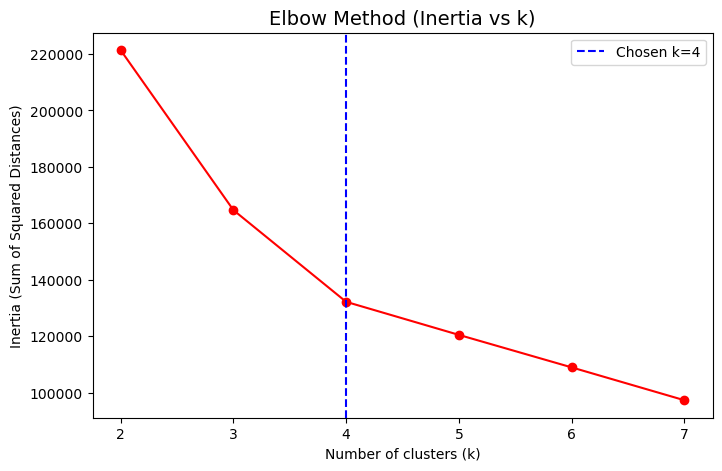

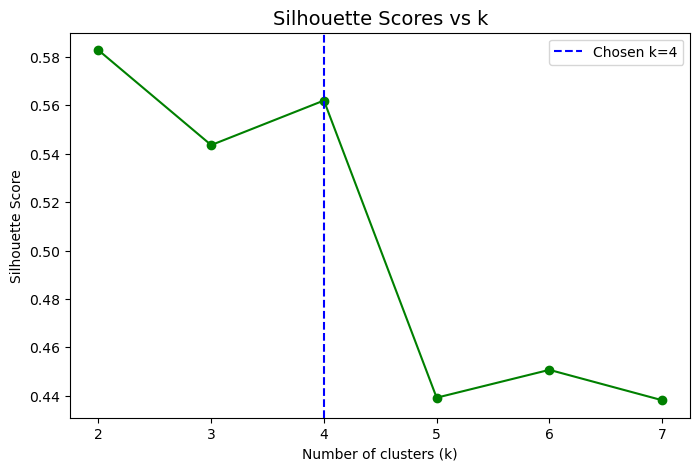

In [ ]:
# Store inertia (Elbow) and silhouette scores for different k values
inertia_list = []
silhouette_scores = []

for k in range(2, 8) :
    kmeans = KMeans(n_clusters=k, random_state=30)
    kmeans.fit(tocluster)

    inertia_list.append(kmeans.inertia_)  # Inertia for elbow method
    silhouette_scores.append(silhouette_score(tocluster, kmeans.labels_))  # Silhouette score

# Elbow Method
plt.figure(figsize=(7,4))
plt.plot(range(2, 8), inertia_list, 'o-', color="red")
plt.axvline(x=4, color='blue', linestyle='--', label="Chosen k=4")
plt.title("Elbow Method (Inertia vs k)", fontsize=14)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.legend()
plt.show()

# Silhouette Scores
plt.figure(figsize=(7,4))
plt.plot(range(2, 8), silhouette_scores, 'o-', color="green")
plt.axvline(x=4, color='blue', linestyle='--', label="Chosen k=4")
plt.title("Silhouette Scores vs k", fontsize=14)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

The optimal number of clusters is 4.

# Train final KMeans model with 4 clusters

In [ ]:
clusterer = KMeans(n_clusters=4, random_state=30).fit(tocluster)
centers = clusterer #coordinates of cluster centroids in PCA space
c_preds = clusterer.predict(tocluster) #assigns each data user to one of the 4 clusters i.e. cluster labels

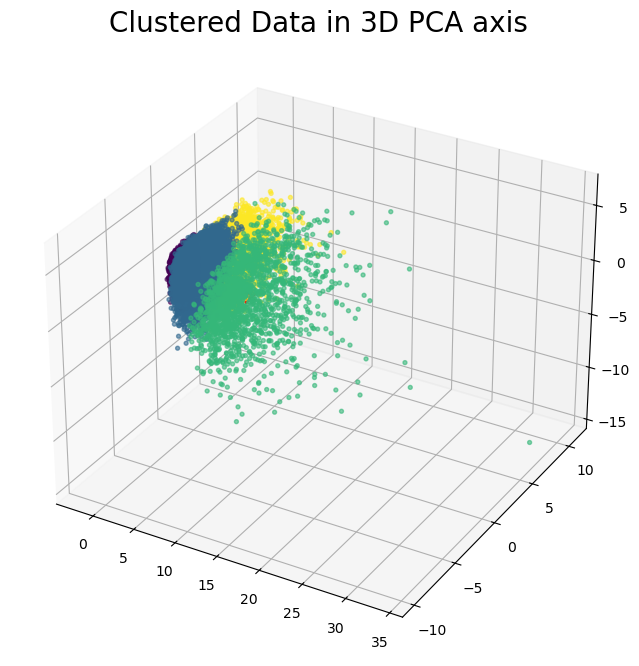

In [ ]:
# 3D visualization
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tocluster["PC1"], tocluster["PC2"], tocluster["PC3"], 
           c=c_preds, s=8, alpha=0.6, cmap='viridis')
ax.scatter(centers[:,0], centers[:,1], centers[:,2], 
           c='red', s=80, marker='X')  # cluster centers
plt.title('Clustered Data in 3D PCA axis', fontsize=20)
plt.show()

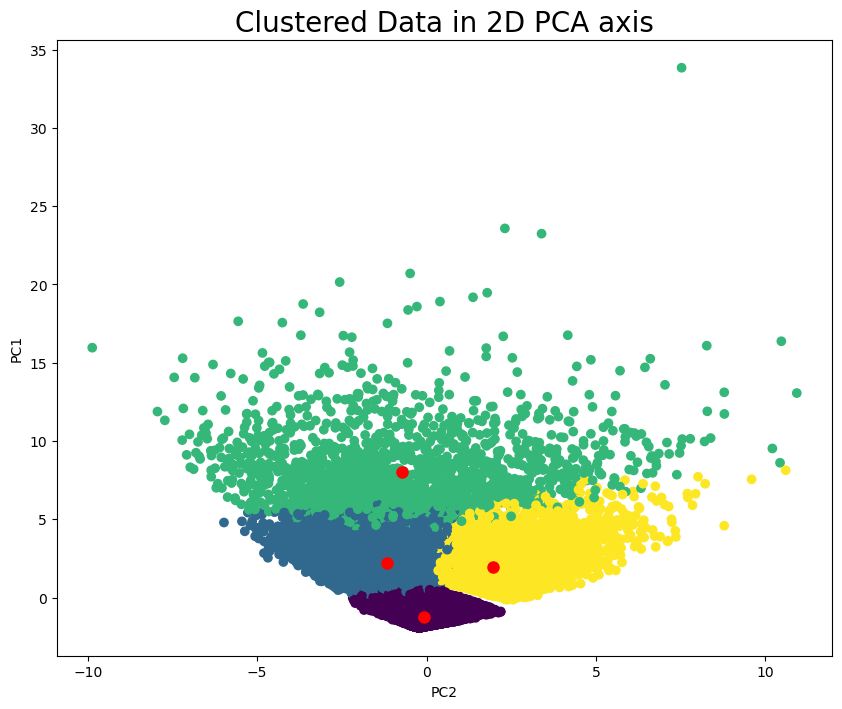

In [ ]:
# 2D visualization
fig = plt.figure(figsize=(10,8))
plt.scatter(tocluster["PC2"], tocluster["PC1"], c = c_preds)
for ci, c in enumerate(centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.title('Clustered Data in 2D PCA axis', fontsize=20)
plt.show()

In [ ]:
# Adding cluster labels to user-anime matrix
user_anime['cluster'] = c_preds
user_anime.head(10)

name     &quot;0&quot;  \
user_id                  
1                    0   
2                    0   
3                    0   
4                    0   
5                    0   
6                    0   
7                    0   
8                    0   
9                    0   
10                   0   

name     &quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu  \
user_id                                                                     
1                                                        0                  
2                                                        0                  
3                                                        0                  
4                                                        0                  
5                                                        0                  
6                                                        0                  
7                                                        0                  
8                                                        0                  
9                                                        0                  
10                                                       0                  

name     &quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi  \
user_id                                                        
1                                                        0     
2                                                        0     
3                                                        0     
4                                                        0     
5                                                        0     
6                                                        0     
7                                                        0     
8                                                        0     
9                                                        0     
10                                                       0     

name     &quot;Bungaku Shoujo&quot; Memoire  &quot;Bungaku Shoujo&quot; Movie  \
user_id                                                                         
1                                         0                                 0   
2                                         0                                 0   
3                                         0                                 0   
4                                         0                                 0   
5                                         0                                 0   
6                                         0                                 0   
7                                         0                                 0   
8                                         0                                 0   
9                                         0                                 0   
10                                        0                                 0   

name     &quot;Eiji&quot;  .hack//G.U. Returner  .hack//G.U. Trilogy  \
user_id                                                                
1                       0                     0                    0   
2                       0                     0                    0   
3                       0                     0                    0   
4                       0                     0                    0   
5                       0                     0                    0   
6                       0                     0                    0   
7                       0                     0                    0   
8                       0                     0                    0   
9                       0                     0                    0   
10                      0                     0                    0   

name     .hack//G.U. Trilogy: Parody Mode  .hack//Gift  ...  \
user_id                                                 ...   
1                            

## Helper functions

### createAnimeInfoList
Given a list of anime names (animelist), the function looks up each anime in your global dataset anime, retrieves key attributes, and organizes them into lists.
Attributes fetched:
- Episodes
- Members
- Rating
- Genre

In [ ]:
def createAnimeInfoList(animelist):
    episode_list, genre_list, member_list, rating_list = [], [], [], []
    
    for x in animelist:
        row = anime[anime['name']==x].iloc[0]
        episode_list.append(int(row.episodes) if pd.notnull(row.episodes) else 0)
        member_list.append(int(row.members) if pd.notnull(row.members) else 0)
        rating_list.append(float(row.rating) if pd.notnull(row.rating) else 0)
        genre_list.append(row.genre if pd.notnull(row.genre) else "")
    
    return genre_list, episode_list, rating_list, member_list

In [ ]:
# Build a global set of all genres across the dataset
set_keywords = set()
for genres in anime['genre'].dropna():
    for g in genres.split(','):
        set_keywords.add(g.strip())

### count_word function
It is the bridge between the local genres (from clusters) and the global set of genres (set_keywords).

In [ ]:
def count_word(df, ref_col, keywords):
    # Initialize counters
    keyword_count = {k: 0 for k in keywords}
    
    # Go through each row in the column
    for genres in df[ref_col].dropna():
        for g in map(str.strip, genres.split(",")):  
            if g in keyword_count:  
                keyword_count[g] += 1
    
    # Sort by frequency
    keyword_occurrences = sorted(keyword_count.items(), key=lambda x: x[1], reverse=True)
    return keyword_occurrences, keyword_count


In [ ]:
# Function to generate wordcloud
def makeCloud(keyword_occurences, title, background_color="white"):
    freq_dict = {k: v for k, v in keyword_occurences if v > 0}
    
    wordcloud = WordCloud(width=800, height=400, 
                          background_color=background_color, 
                          colormap='viridis').generate_from_frequencies(freq_dict)
    
    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=18)
    plt.show()

# Analyze clusters

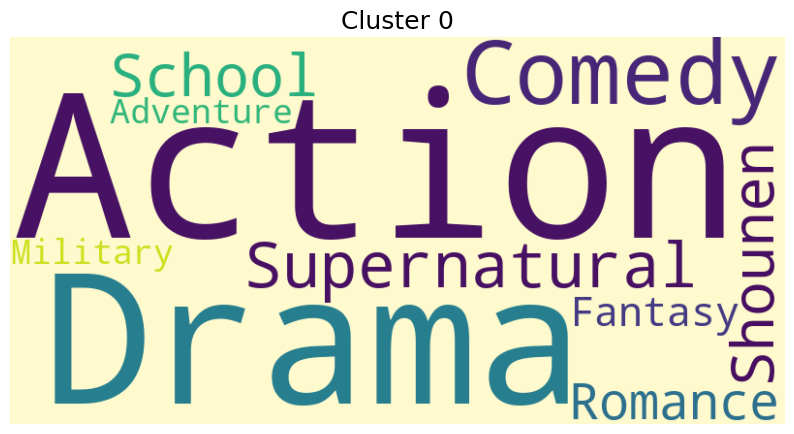

Cluster 0
AVG episode : 39.93
AVG rating  : 8.44
AVG member  : 683744.00



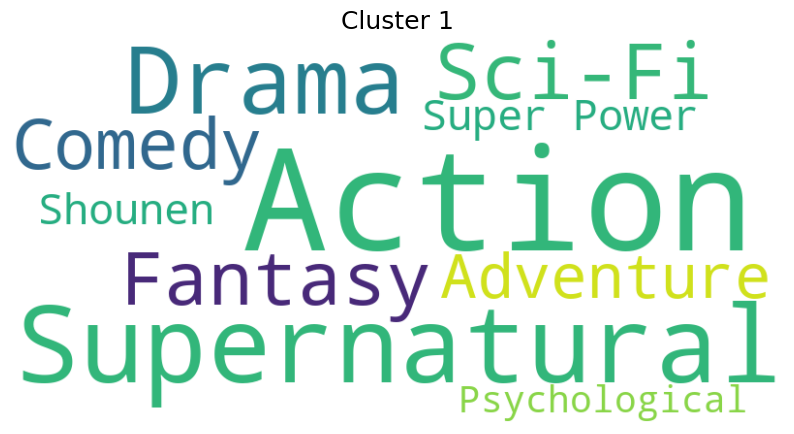

Cluster 1
AVG episode : 23.20
AVG rating  : 8.56
AVG member  : 687956.20



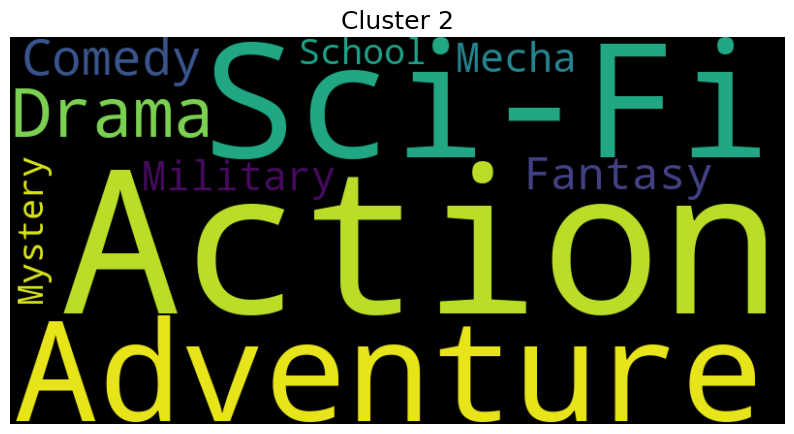

Cluster 2
AVG episode : 24.73
AVG rating  : 8.70
AVG member  : 575941.47



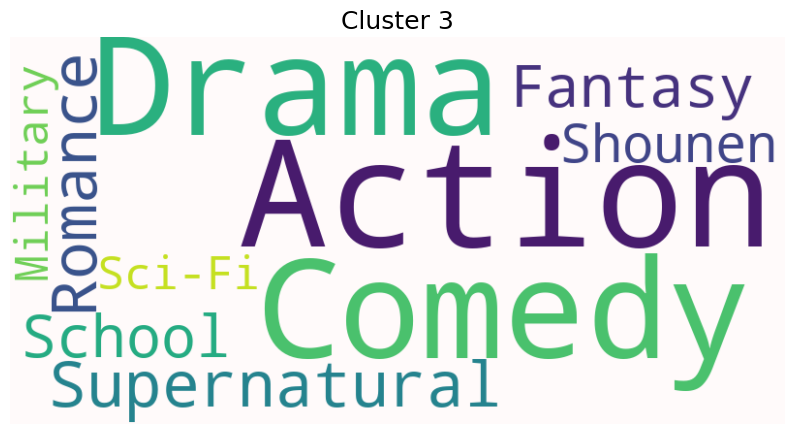

Cluster 3
AVG episode : 24.27
AVG rating  : 8.49
AVG member  : 668134.00



In [ ]:
# Compute mean vectors for each cluster
c0 = user_anime[user_anime['cluster']==0].drop('cluster',axis=1).mean()
c1 = user_anime[user_anime['cluster']==1].drop('cluster',axis=1).mean()
c2 = user_anime[user_anime['cluster']==2].drop('cluster',axis=1).mean()
c3 = user_anime[user_anime['cluster']==3].drop('cluster',axis=1).mean()


# Function to summarize cluster
def summarize_cluster(cluster_vector, cluster_name, color):
    animelist = list(cluster_vector.sort_values(ascending=False)[0:15].index)
    data = pd.DataFrame()
    data['genre'],data['episode'],data['rating'],data['member'] = createAnimeInfoList(animelist)
    keyword_occurences, _ = count_word(data, 'genre', set_keywords)
    
    makeCloud(keyword_occurences[0:10], f"Cluster {cluster_name}", color)
    print(f"Cluster {cluster_name}")
    print(f"AVG episode : {data['episode'].mean():.2f}")
    print(f"AVG rating  : {data['rating'].mean():.2f}")
    print(f"AVG member  : {data['member'].mean():.2f}\n")


# Summarize all clusters
summarize_cluster(c0, 0, "lemonchiffon")
summarize_cluster(c1, 1, "white")
summarize_cluster(c2, 2, "black")
summarize_cluster(c3, 3, "snow")
